# Pipeline de aprendizado de máquina

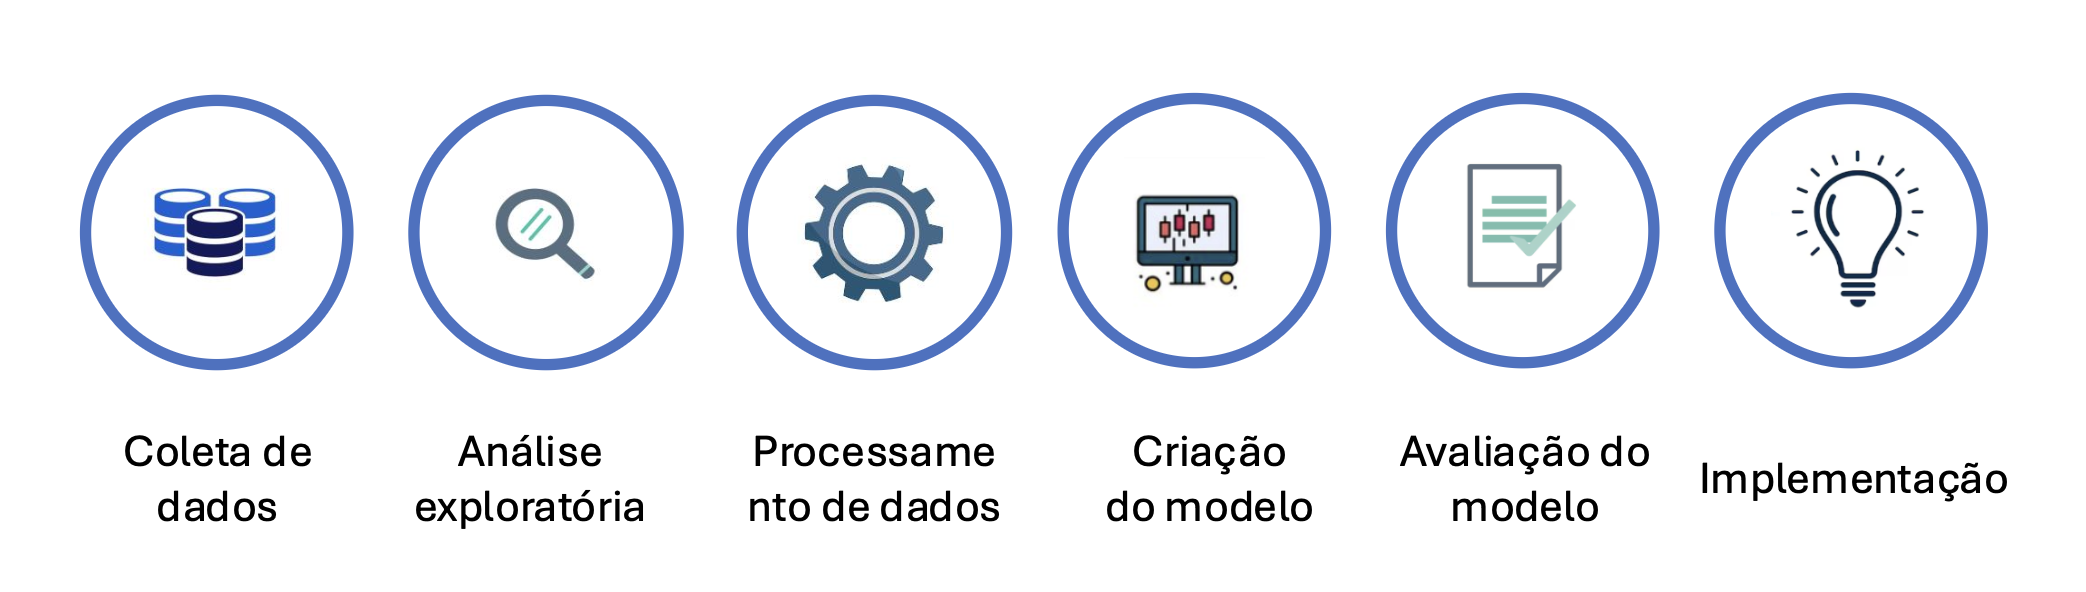

In [ ]:
!pip install kagglehub[pandas-datasets]

zsh:1: no matches found: kagglehub[pandas-datasets]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

print("PIPELINE COMPLETO DE MACHINE LEARNING")
print("Dataset: Student Performance")
print("=" * 60)

# =====================================
# FASE 1: COLETA DE DADOS
# =====================================

print("FASE 1: COLETA DE DADOS")
print("=" * 40)

# Título do arquivo a ser descarregado
file_path = "Student_Performance.csv"

# Coleta de dados e armazenamento em dataframe Pandas
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,
                           "nikhil7280/student-performance-multiple-linear-regression",
                           file_path)

print(f"Dataset carregado com sucesso!")
print(f"Dimensões: {df.shape}")
print(f"Colunas: {list(df.columns)}")

# =====================================
# FASE 2: ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)
# =====================================

print(f"FASE 2: ANÁLISE EXPLORATÓRIA DOS DADOS")
print("=" * 50)

# 2.1 Informações básicas do dataset
print(f"INFORMAÇÕES BÁSICAS:")
print(f"Forma do dataset: {df.shape}")
print(f"Número de linhas: {df.shape[0]:,}")
print(f"Número de colunas: {df.shape[1]}")

print(f"PRIMEIRAS 5 LINHAS:")
print(df.head())

print(f"INFORMAÇÕES DAS COLUNAS:")
print(df.info())

# 2.2 Verificar valores ausentes
print(f"VALORES AUSENTES:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Coluna': missing_values.index,
    'Valores Ausentes': missing_values.values,
    'Percentual (%)': missing_percent.values
}).round(2)

print(missing_df[missing_df['Valores Ausentes'] > 0])
if missing_values.sum() == 0:
    print("Nenhum valor ausente encontrado!")

# 2.3 Identificar tipos de variáveis
print(f"TIPOS DE VARIÁVEIS:")
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numéricas ({len(numeric_columns)}): {numeric_columns}")
print(f"Categóricas ({len(categorical_columns)}): {categorical_columns}")

# 2.4 Estatísticas descritivas
print(f"ESTATÍSTICAS DESCRITIVAS (Variáveis Numéricas):")
print(df[numeric_columns].describe().round(2))

if categorical_columns:
    print(f"ESTATÍSTICAS DESCRITIVAS (Variáveis Categóricas):")
    print(df[categorical_columns].describe())

# 2.5 Identificar variável alvo (target)
print(f"IDENTIFICANDO VARIÁVEL ALVO:")
# Procurar por possíveis variáveis alvo
target_keywords = ['score', 'grade', 'performance', 'mark', 'result', 'achievement', 'gpa']
possible_targets = []

for col in df.columns:
    if any(keyword in col.lower() for keyword in target_keywords):
        possible_targets.append(col)

if possible_targets:
    target_column = possible_targets[0]
    print(f"Variável alvo identificada: '{target_column}'")
else:
    # Se não encontrar, usar a última coluna numérica
    if numeric_columns:
        target_column = numeric_columns[-1]
        print(f"Usando última coluna numérica como alvo: '{target_column}'")
    else:
        print("Erro: Nenhuma variável alvo numérica encontrada!")
        exit()

print(f"Estatísticas da variável alvo '{target_column}':")
print(f" Média: {df[target_column].mean():.2f}")
print(f" Mediana: {df[target_column].median():.2f}")
print(f" Desvio padrão: {df[target_column].std():.2f}")
print(f" Mínimo: {df[target_column].min():.2f}")
print(f" Máximo: {df[target_column].max():.2f}")

# 2.6 Visualizações exploratórias
print(f"CRIANDO VISUALIZAÇÕES EXPLORATÓRIAS...")

# Configurar estilo dos gráficos
plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# Gráfico 1: Distribuição da variável alvo
plt.subplot(3, 4, 1)
plt.hist(df[target_column], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel(target_column)
plt.ylabel('Frequência')
plt.title(f'Distribuição de {target_column}')
plt.grid(True, alpha=0.3)

# Gráfico 2: Boxplot da variável alvo
plt.subplot(3, 4, 2)
plt.boxplot(df[target_column])
plt.ylabel(target_column)
plt.title(f'Boxplot de {target_column}')
plt.grid(True, alpha=0.3)

# Gráfico 3: Q-Q plot para normalidade
plt.subplot(3, 4, 3)
stats.probplot(df[target_column], dist="norm", plot=plt)
plt.title(f'Q-Q Plot - {target_column}')
plt.grid(True, alpha=0.3)

# Gráfico 4: Correlação entre variáveis numéricas
if len(numeric_columns) > 1:
    plt.subplot(3, 4, 4)
    correlation_matrix = df[numeric_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
    plt.title('Matriz de Correlação')

# Gráficos 5-8: Distribuições das principais variáveis numéricas
numeric_features = [col for col in numeric_columns if col != target_column][:4]
for i, col in enumerate(numeric_features):
    plt.subplot(3, 4, 5 + i)
    plt.hist(df[col], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de {col}')
    plt.grid(True, alpha=0.3)

# Gráficos 9-12: Scatter plots com a variável alvo
for i, col in enumerate(numeric_features[:4]):
    plt.subplot(3, 4, 9 + i)
    plt.scatter(df[col], df[target_column], alpha=0.6, color='coral')
    plt.xlabel(col)
    plt.ylabel(target_column)
    plt.title(f'{col} vs {target_column}')
    plt.grid(True, alpha=0.3)

    # Adicionar linha de tendência
    z = np.polyfit(df[col], df[target_column], 1)
    p = np.poly1d(z)
    plt.plot(df[col], p(df[col]), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# 2.7 Análise de correlação detalhada
print(f"ANÁLISE DE CORRELAÇÃO COM A VARIÁVEL ALVO:")
if len(numeric_columns) > 1:
    correlations = df[numeric_columns].corr()[target_column].sort_values(ascending=False)
    print("Correlações (ordenadas por força):")
    for col, corr in correlations.items():
        if col != target_column:
            strength = "Forte" if abs(corr) > 0.7 else "Moderada" if abs(corr) > 0.3 else "Fraca"
            direction = "Positiva" if corr > 0 else "Negativa"
            print(f"   {col}: {corr:.3f} ({strength} {direction})")

# =====================================
# FASE 3: PROCESSAMENTO DE DADOS
# =====================================

print(f"FASE 3: PROCESSAMENTO DE DADOS")
print("=" * 40)

# 3.1 Cópia dos dados para processamento
df_processed = df.copy()
print(f"Cópia dos dados criada para processamento")

# 3.2 Tratamento de valores ausentes
print(f"TRATAMENTO DE VALORES AUSENTES:")
if df_processed.isnull().sum().sum() > 0:
    print("Preenchendo valores ausentes...")
    # Para variáveis numéricas: usar mediana
    for col in numeric_columns:
        if df_processed[col].isnull().sum() > 0:
            median_value = df_processed[col].median()
            df_processed[col].fillna(median_value, inplace=True)
            print(f"   {col}: preenchido com mediana ({median_value:.2f})")

    # Para variáveis categóricas: usar moda
    for col in categorical_columns:
        if df_processed[col].isnull().sum() > 0:
            mode_value = df_processed[col].mode()[0]
            df_processed[col].fillna(mode_value, inplace=True)
            print(f"   {col}: preenchido com moda ({mode_value})")
else:
    print("Nenhum valor ausente para tratar!")

# 3.3 Codificação de variáveis categóricas
print(f"CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS:")
if categorical_columns:
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le

        unique_values = df_processed[col].nunique()
        print(f"   {col}: {unique_values} categorias únicas → {col}_encoded")

        # Mostrar mapeamento se houver poucas categorias
        if unique_values <= 10:
            mapping = dict(zip(le.classes_, le.transform(le.classes_)))
            print(f"      Mapeamento: {mapping}")

    # Atualizar lista de colunas categóricas codificadas
    encoded_columns = [col + '_encoded' for col in categorical_columns]
    print(f"{len(categorical_columns)} variáveis categóricas codificadas")
else:
    encoded_columns = []
    print("Nenhuma variável categórica para codificar!")

# 3.4 Detecção e tratamento de outliers
print(f"DETECÇÃO DE OUTLIERS:")
outlier_info = {}

for col in numeric_columns:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_processed[(df_processed[col] < lower_bound) |
                           (df_processed[col] > upper_bound)]

    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df_processed)) * 100

    outlier_info[col] = {
        'count': outlier_count,
        'percent': outlier_percent,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    print(f"   {col}: {outlier_count} outliers ({outlier_percent:.1f}%)")

# Decidir se remover outliers extremos (>5% dos dados)
outliers_to_remove = []
for col, info in outlier_info.items():
    if info['percent'] > 5 and col != target_column:  # Não remover outliers da variável alvo
        print(f"{col} tem muitos outliers ({info['percent']:.1f}%) - considerar investigação")

# 3.5 Seleção de features para o modelo
print(f"SELEÇÃO DE FEATURES:")
# Combinar variáveis numéricas (exceto target) e categóricas codificadas
feature_columns = [col for col in numeric_columns if col != target_column] + encoded_columns

print(f"Features selecionadas ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i}. {col}")

# 3.6 Preparar dados para o modelo
X = df_processed[feature_columns]
y = df_processed[target_column]

print(f"DADOS PREPARADOS PARA MODELAGEM:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")

# =====================================
# FASE 4: CRIAÇÃO DO MODELO
# =====================================

print(f"FASE 4: CRIAÇÃO DO MODELO")
print("=" * 35)

# 4.1 Divisão dos dados
print(f"DIVISÃO DOS DADOS:")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"   Treino: {X_train.shape[0]} amostras ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"   Teste: {X_test.shape[0]} amostras ({(X_test.shape[0]/len(X))*100:.1f}%)")

# 4.2 Padronização das features (opcional para regressão linear, mas boa prática)
print(f"PADRONIZAÇÃO DAS FEATURES:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features padronizadas (média=0, desvio=1)")
print(f" Médias após padronização: {X_train_scaled.mean(axis=0).round(3)}")
print(f" Desvios após padronização: {X_train_scaled.std(axis=0).round(3)}")

# 4.3 Criação e treinamento do modelo
print(f"CRIAÇÃO DO MODELO DE REGRESSÃO LINEAR:")
model = LinearRegression()

# Treinar o modelo
print(f"🏋️ Treinando modelo...")
model.fit(X_train_scaled, y_train)

print(f"Modelo treinado com sucesso!")
print(f" Intercepto: {model.intercept_:.3f}")
print(f" Número de coeficientes: {len(model.coef_)}")

# 4.4 Análise dos coeficientes
print(f"ANÁLISE DOS COEFICIENTES:")
coefficients_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coeficiente': model.coef_,
    'Abs_Coeficiente': np.abs(model.coef_)
}).sort_values('Abs_Coeficiente', ascending=False)

print("Top 10 features mais importantes (por magnitude do coeficiente):")
for i, row in coefficients_df.head(10).iterrows():
    direction = "up" if row['Coeficiente'] > 0 else "down"
    print(f"   {direction} {row['Feature']}: {row['Coeficiente']:+.3f}")

# =====================================
# FASE 5: AVALIAÇÃO DO MODELO
# =====================================

print(f"FASE 5: AVALIAÇÃO DO MODELO")
print("=" * 40)

# 5.1 Predições
print(f"FAZENDO PREDIÇÕES:")
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f"Predições realizadas para treino e teste")

# 5.2 Métricas de avaliação
print(f"MÉTRICAS DE PERFORMANCE:")

# Métricas de treino
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Métricas de teste
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"TREINO:")
print(f"   R² Score: {train_r2:.4f} ({train_r2*100:.2f}%)")
print(f"   RMSE: {train_rmse:.3f}")
print(f"   MAE: {train_mae:.3f}")

print(f"TESTE:")
print(f"   R² Score: {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"   RMSE: {test_rmse:.3f}")
print(f"   MAE: {test_mae:.3f}")

# 5.3 Análise de overfitting/underfitting
print(f"ANÁLISE DE OVERFITTING:")
r2_diff = train_r2 - test_r2
print(f"   Diferença R² (treino - teste): {r2_diff:+.4f}")

if r2_diff > 0.1:
    print(f"POSSÍVEL OVERFITTING - Modelo muito ajustado ao treino")
elif r2_diff < -0.05:
    print(f"RESULTADO INUSUAL - Teste melhor que treino")
else:
    print(f"BOA GENERALIZAÇÃO - Diferença aceitável")

# 5.4 Validação cruzada
print(f"VALIDAÇÃO CRUZADA:")
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"   R² médio (5-fold CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"   Scores individuais: {cv_scores.round(4)}")

# 5.5 Importância das features
print(f"\n🎯 IMPORTÂNCIA DAS FEATURES (Permutation Importance):")
perm_importance = permutation_importance(model, X_test_scaled, y_test,
                                       n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("Top 10 features mais importantes:")
for i, row in importance_df.head(10).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f} ± {row['Std']:.4f}")

# 5.6 Visualizações de avaliação
print(f"CRIANDO VISUALIZAÇÕES DE AVALIAÇÃO...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Gráfico 1: Valores reais vs preditos (treino)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reais')
axes[0, 0].set_ylabel('Valores Preditos')
axes[0, 0].set_title(f'Treino: Real vs Predito\nR² = {train_r2:.3f}')
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Valores reais vs preditos (teste)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Valores Reais')
axes[0, 1].set_ylabel('Valores Preditos')
axes[0, 1].set_title(f'Teste: Real vs Predito\nR² = {test_r2:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Resíduos vs preditos
residuals_test = y_test - y_test_pred
axes[0, 2].scatter(y_test_pred, residuals_test, alpha=0.6, color='red')
axes[0, 2].axhline(y=0, color='black', linestyle='--')
axes[0, 2].set_xlabel('Valores Preditos')
axes[0, 2].set_ylabel('Resíduos')
axes[0, 2].set_title('Análise de Resíduos')
axes[0, 2].grid(True, alpha=0.3)

# Gráfico 4: Distribuição dos resíduos
axes[1, 0].hist(residuals_test, bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 0].set_xlabel('Resíduos')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].set_title('Distribuição dos Resíduos')
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 5: Q-Q plot dos resíduos
stats.probplot(residuals_test, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot dos Resíduos')
axes[1, 1].grid(True, alpha=0.3)

# Gráfico 6: Importância das features
top_features = importance_df.head(10)
axes[1, 2].barh(range(len(top_features)), top_features['Importance'])
axes[1, 2].set_yticks(range(len(top_features)))
axes[1, 2].set_yticklabels([feat.replace('_', '\n') for feat in top_features['Feature']])
axes[1, 2].set_xlabel('Importância')
axes[1, 2].set_title('Top 10 Features Mais Importantes')
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# =====================================
# RELATÓRIO FINAL
# =====================================

print(f"\n" + "=" * 60)
print(f"RELATÓRIO FINAL DO PIPELINE")
print("=" * 60)

print(f"RESUMO DO DATASET:")
print(f"  Total de amostras: {len(df):,}")
print(f"  Features utilizadas: {len(feature_columns)}")
print(f"  Variável alvo: {target_column}")
print(f"  Faixa do target: {y.min():.2f} - {y.max():.2f}")

print(f"QUALIDADE DO MODELO:")
print(f"  R² Score (teste): {test_r2:.4f} ({test_r2*100:.1f}%)")
print(f"  RMSE (teste): {test_rmse:.3f}")
print(f"  MAE (teste): {test_mae:.3f}")

# Interpretação da qualidade
if test_r2 > 0.8:
    quality = "EXCELENTE"
elif test_r2 > 0.6:
    quality = "BOM"
elif test_r2 > 0.4:
    quality = "MODERADO"
else:
    quality = "FRACO"

print(f"Qualidade geral: {quality}")

print(f"FEATURES MAIS IMPORTANTES:")
for i, row in importance_df.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"DIAGNÓSTICOS:")
if abs(r2_diff) < 0.05:
    print(f"Modelo bem generalizado")
else:
    print(f"Diferença entre treino e teste: {r2_diff:+.4f}")

# Análise dos resíduos
shapiro_stat, shapiro_p = stats.shapiro(residuals_test[:5000] if len(residuals_test) > 5000 else residuals_test)
if shapiro_p > 0.05:
    print(f"Resíduos seguem distribuição normal")
else:
    print(f"Resíduos não seguem distribuição normal")

print(f"RECOMENDAÇÕES:")
if test_r2 < 0.6:
    print(f"Considerar feature engineering")
    print(f"Testar modelos mais complexos")
    print(f"Coletar mais dados")
elif r2_diff > 0.1:
    print(f"Aplicar regularização")
    print(f"Reduzir complexidade do modelo")
else:
    print(f"Modelo está bem ajustado!")
    print(f"Pronto para produção (com monitoramento)")

print(f"EXEMPLO DE PREDIÇÃO:")
example_idx = 0
example_features = X_test_scaled[example_idx:example_idx+1]
example_pred = model.predict(example_features)[0]
example_real = y_test.iloc[example_idx]

print(f"   Valor real: {example_real:.2f}")
print(f"   Valor predito: {example_pred:.2f}")
print(f"   Erro absoluto: {abs(example_real - example_pred):.2f}")
print(f"   Erro percentual: {abs(example_real - example_pred)/example_real*100:.1f}%")

print(f"PIPELINE COMPLETO FINALIZADO COM SUCESSO!")
print(f"Todas as 5 fases foram executadas:")
print(f"1. Coleta de Dados")
print(f"2. Análise Exploratória")
print(f"3. Processamento de Dados")
print(f"4. Criação do Modelo")
print(f"5. Avaliação do Modelo")

ModuleNotFoundError: No module named 'kagglehub'